In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import Word
set(stopwords.words('english'))
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Global Parameters
stop_words = set(stopwords.words('english'))

In [ ]:
#Load new dataset
data = pd.read_csv('/content/gdrive/My Drive/PhD/Program_Doc/Assignment/Project_Dataset/Labelled_Pos_Neg.csv')
data.head()

,username,author_location,text,created_at,Text_punc,Text_stop,Text_tokenized,Text_lemmatized,Text_cleaned,Sentiment,neg,neu,pos,compound
0,cloudslicer,NaN,this creeping extension of social control and ...,2021-02-14 23:49:18+00:00,this creeping extension of social control and ...,creeping extension social control power state ...,"['creeping', 'extension', 'social', 'control',...","['creeping', 'extension', 'social', 'control',...",creeping extension social control power state ...,positive,0.000,0.833,0.167,0.2023
1,JohnStauber,Citizen-at-Large,#vaccinepassports' could be used inside the un...,2021-02-14 23:45:25+00:00,vaccinepassports could be used inside the unit...,vaccinepassports could used inside united kingdom,"['vaccinepassports', 'could', 'used', 'inside'...","['vaccinepassports', 'could', 'used', 'inside'...",vaccinepassports could used inside united kingdom,positive,0.000,0.641,0.359,0.4215
2,SRL_82,"Melton Mowbray, England",the uk should take the lead in creating a glob...,2021-02-14 23:43:01+00:00,the uk should take the lead in creating a glob...,uk take lead creating global coronavirus vacci...,"['uk', 'take', 'lead', 'creating', 'global', '...","['uk', 'take', 'lead', 'creating', 'global', '...",uk take lead creating global coronavirus vacci...,positive,0.000,0.686,0.314,0.6705
3,flackster,Middle-earth,"🏁100,000 signatures received - thank you! 🏁🙏we...",2021-02-14 23:28:10+00:00,100000 signatures received thank you were gra...,100000 signatures received thank grateful ever...,"['100000', 'signatures', 'received', 'thank', ...","['100000', 'signature', 'received', 'thank', '...",100000 signature received thank grateful every...,positive,0.000,0.448,0.552,0.7497
4,shalomegrace1,NaN,here's the war criminal pushing #vaccinepasspo...,2021-02-14 23:19:49+00:00,heres the war criminal pushing vaccinepassport...,heres war criminal pushing vaccinepassports ev...,"['heres', 'war', 'criminal', 'pushing', 'vacci...","['here', 'war', 'criminal', 'pushing', 'vaccin...",here war criminal pushing vaccinepassports eve...,negative,0.554,0.446,0.000,-0.8271


In [ ]:
def to_sentiment(rating):
  #rating = int(rating)
  if rating == "neutral":
    return 0
  elif rating == "positive":
    return 1
  else: 
    return 2

data['label'] = data.Sentiment.apply(to_sentiment)

In [ ]:
def remove_unwanted_cols(dataset, cols):
    for col in cols:
        del dataset[col]
    return dataset

In [ ]:
data = remove_unwanted_cols(data, ['Text_cleaned', 'Sentiment', 'Text_punc', 'Text_tokenized','neu','pos','neg',
                                      'created_at', 'username', 'author_location', 'Text_stop','Text_lemmatized','compound'])
data.head()

,text,label
0,this creeping extension of social control and ...,1
1,#vaccinepassports' could be used inside the un...,1
2,the uk should take the lead in creating a glob...,1
3,"🏁100,000 signatures received - thank you! 🏁🙏we...",1
4,here's the war criminal pushing #vaccinepasspo...,2


In [ ]:
def preprocess_tweet_text(tweet):
    tweet = str(tweet).lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', str(tweet), flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', str(tweet))
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    #ps = PorterStemmer()
    #stemmed_words = [ps.stem(w) for w in filtered_words]
    #lemmatizer = WordNetLemmatizer()
    #lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    
    return " ".join(filtered_words)

In [ ]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector

In [ ]:
data.head()

,text,label
0,this creeping extension of social control and ...,1
1,#vaccinepassports' could be used inside the un...,1
2,the uk should take the lead in creating a glob...,1
3,"🏁100,000 signatures received - thank you! 🏁🙏we...",1
4,here's the war criminal pushing #vaccinepasspo...,2


In [ ]:
titles = list(data.columns)
titles

['text', 'label']

In [ ]:
titles[0],titles[1] = titles[1],titles[0]
titles

['label', 'text']

In [ ]:
data = data[titles]
data

,label,text
0,1,this creeping extension of social control and ...
1,1,#vaccinepassports' could be used inside the un...
2,1,the uk should take the lead in creating a glob...
3,1,"🏁100,000 signatures received - thank you! 🏁🙏we..."
4,2,here's the war criminal pushing #vaccinepasspo...
...,...,...
40606,1,goes to show what total #covid19 bs we're all ...
40607,1,public is being misled re: #vaccinepass...
40608,1,"whitsundays, hamilton, alice springs top autu..."
40609,2,how many of the anti vaccine passport people d...


In [ ]:
#Preprocess data
data.text = data['text'].apply(preprocess_tweet_text)

In [ ]:
# Same tf vector will be used for Testing sentiments on unseen trending data
tf_vector = get_feature_vector(np.array(data.iloc[:, 1]).ravel())
X = tf_vector.transform(np.array(data.iloc[:, 1]).ravel())
y = np.array(data.iloc[:, 0]).ravel()

In [ ]:
#Cross Validation

from sklearn import metrics
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import KFold

svm= SVC(kernel='linear')
NB = MultinomialNB()
LR = LogisticRegression(solver='sag')
RF = RandomForestClassifier(n_estimators=200)

In [ ]:
# Define report generator

def generate_report(cmatrix, score, creport):
  """Generates and displays graphical reports
  Keyword arguments:
    cmatrix - Confusion matrix generated by the model
    score --- Score generated by the model
    creport - Classification Report generated by the model
    
  :Returns -- N/A
  """
  
  # Generate confusion matrix heatmap
  plt.figure(figsize=(5,5))
  sns.heatmap(cmatrix, 
              annot=True, 
              fmt="d", 
              linewidths=.5, 
              square = True, 
              cmap = 'Blues', 
              annot_kws={"size": 16}, 
              xticklabels=['Negative', 'Positive'],
              yticklabels=['Negative', 'Positive'])

  plt.xticks(rotation='horizontal', fontsize=16)
  plt.yticks(rotation='horizontal', fontsize=16)
  plt.xlabel('Actual Label', size=20);
  plt.ylabel('Predicted Label', size=20);

  title = 'Accuracy Score: {0:.4f}'.format(score)
  plt.title(title, size = 20);

  # Display classification report and confusion matrix
  print(creport)
  plt.show()
  

print("\n### Report Generator Defined ###\n")


### Report Generator Defined ###



In [ ]:
kf = KFold(n_splits=10,random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]


### Model Built for LR ###

              precision    recall  f1-score   support

           1       0.92      0.84      0.88      2709
           2       0.72      0.85      0.78      1352

    accuracy                           0.84      4061
   macro avg       0.82      0.85      0.83      4061
weighted avg       0.85      0.84      0.85      4061



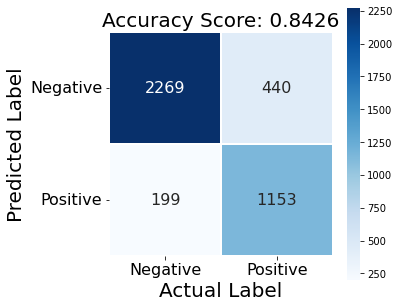

In [ ]:
#Logistic Regression
# Train the model
LR.fit(X_train, y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_lr = LR.score(X_test, y_test)
predictions_lr = LR.predict(X_test)
cmatrix_lr = metrics.confusion_matrix(predictions_lr,y_test)
creport_lr = metrics.classification_report(predictions_lr, y_test)

print("\n### Model Built for LR ###\n")
generate_report(cmatrix_lr, score_lr, creport_lr)


### Model Built for NB ###

              precision    recall  f1-score   support

           1       0.90      0.73      0.80      3063
           2       0.47      0.75      0.58       998

    accuracy                           0.73      4061
   macro avg       0.69      0.74      0.69      4061
weighted avg       0.80      0.73      0.75      4061



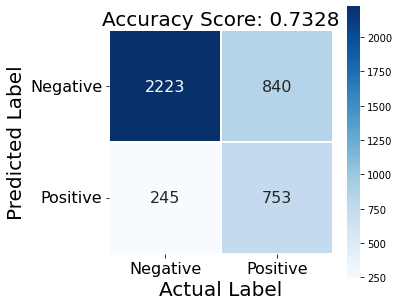

In [ ]:
#NaiveBayes
# Train the model
NB.fit(X_train, y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_nb = NB.score(X_test, y_test)
predictions_nb = NB.predict(X_test)
cmatrix_nb = metrics.confusion_matrix(predictions_nb,y_test)
creport_nb = metrics.classification_report(predictions_nb, y_test)

print("\n### Model Built for NB ###\n")
generate_report(cmatrix_nb, score_nb, creport_nb)


### Model Built for SVM ###

              precision    recall  f1-score   support

           1       0.91      0.85      0.88      2653
           2       0.75      0.85      0.80      1408

    accuracy                           0.85      4061
   macro avg       0.83      0.85      0.84      4061
weighted avg       0.86      0.85      0.85      4061



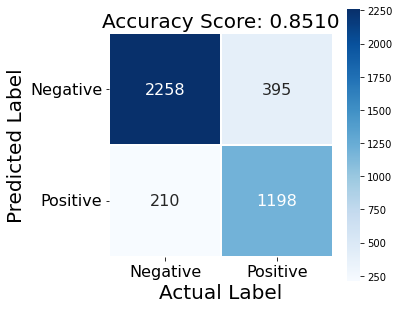

In [ ]:
#SVM
# Train the model
svm.fit(X_train, y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_svm = svm.score(X_test, y_test)
predictions_svm = svm.predict(X_test)
cmatrix_svm = metrics.confusion_matrix(predictions_svm,y_test)
creport_svm = metrics.classification_report(predictions_svm, y_test)

print("\n### Model Built for SVM ###\n")
generate_report(cmatrix_svm, score_svm, creport_svm)


### Model Built for RF ###

              precision    recall  f1-score   support

           1       0.92      0.80      0.86      2830
           2       0.65      0.84      0.73      1231

    accuracy                           0.81      4061
   macro avg       0.79      0.82      0.80      4061
weighted avg       0.84      0.81      0.82      4061



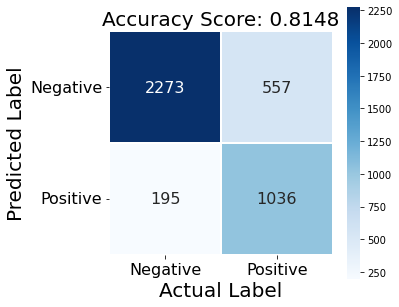

In [ ]:
#Random Forest
# Train the model
RF.fit(X_train, y_train)


# Test the mode (score, predictions, confusion matrix, classification report)
score_rf = RF.score(X_test, y_test)
predictions_rf = RF.predict(X_test)
cmatrix_rf = metrics.confusion_matrix(predictions_rf,y_test)
creport_rf = metrics.classification_report(predictions_rf, y_test)

print("\n### Model Built for RF ###\n")
generate_report(cmatrix_rf, score_rf, creport_rf)

In [ ]:
#Cross Validation

from sklearn import metrics
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import KFold

svm= SVC()
NB = MultinomialNB()
LR = LogisticRegression(solver='sag')
RF = RandomForestClassifier()

label = ['Logistic Regression', 'Naives Bayes', 'SVM', 'RandomForest']
b_list=[LR,NB,svm,RF]
clf_cv_mean = []
clf_cv_std = []
for clf, label in zip(b_list, label):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    scores_recall = cross_val_score(clf, X, y, cv=10, scoring='recall')
    scores_pre = cross_val_score(clf, X, y, cv=10, scoring='precision')
    scores_f1 = cross_val_score(clf, X, y, cv=10, scoring='f1')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    print ("Recall: %.2f (+/- %.2f) [%s]" %(scores_recall.mean(), scores_recall.std(), label))
    print ("Precision: %.2f (+/- %.2f) [%s]" %(scores_pre.mean(), scores_pre.std(), label))
    print ("F1_Score: %.2f (+/- %.2f) [%s]" %(scores_f1.mean(), scores_f1.std(), label))
    #clf_cv_mean.append(scores.mean())
    #clf_cv_std.append(scores.std())

Accuracy: 0.84 (+/- 0.01) [Logistic Regression]
Recall: 0.90 (+/- 0.02) [Logistic Regression]
Precision: 0.83 (+/- 0.01) [Logistic Regression]
F1_Score: 0.87 (+/- 0.01) [Logistic Regression]
Accuracy: 0.75 (+/- 0.02) [Naives Bayes]
Recall: 0.93 (+/- 0.02) [Naives Bayes]
Precision: 0.72 (+/- 0.02) [Naives Bayes]
F1_Score: 0.81 (+/- 0.01) [Naives Bayes]


In [ ]:
# Split dataset into Train, Test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print("MultinomialNB(): " + str(accuracy_score(y_test, y_predict_nb)))






MultinomialNB(): 0.687474265008647


In [ ]:
# Training Logistics Regression model
LR_model = LogisticRegression(solver='lbfgs')
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print("Logistic Regression: " + str(accuracy_score(y_test, y_predict_lr)))

Logistic Regression: 0.8567899201185868


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
